In [1]:
#Import necessary python libraries
import pandas as pd
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd

# Load CSV files
politifact_fake = pd.read_csv("/politifactfake.csv")
politifact_real = pd.read_csv("/politifactreal.csv")
gossipcop_fake = pd.read_csv("/gossipcopfake.csv")
gossipcop_real = pd.read_csv("/gossipcopreal.csv")

# Combine all datasets
fake_data = pd.concat([politifact_fake, gossipcop_fake])
real_data = pd.concat([politifact_real, gossipcop_real])

# Add labels
fake_data["label"] = 0  # Fake
real_data["label"] = 1  # Real

# Merge into a single DataFrame
dataset = pd.concat([fake_data, real_data], ignore_index=True)

#Drop rows with missing titles
dataset = dataset.dropna(subset=["title"])

In [7]:
# 1. Text Preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text.strip()

# Make sure to import re at the top of your file
import re

# Then apply preprocessing
dataset["cleaned_title"] = dataset["title"].apply(preprocess_text)

In [8]:
# 2. Named Entity Recognition (NER)
# Load SpaCy language model
nlp = spacy.load("en_core_web_sm")

# Function to extract named entities
def get_entities(text):
    doc = nlp(text)
    entities = {"organizations": 0, "locations": 0, "people": 0}
    for ent in doc.ents:
        if ent.label_ == "ORG":
            entities["organizations"] += 1
        elif ent.label_ == "GPE":
            entities["locations"] += 1
        elif ent.label_ == "PERSON":
            entities["people"] += 1
    return entities

# Apply NER on the cleaned titles
ner_features = dataset["cleaned_title"].apply(get_entities)
ner_features_df = pd.DataFrame(ner_features.tolist())

# Add NER features to the dataset
dataset = pd.concat([dataset, ner_features_df], axis=1)

In [9]:
# 3. Additional Feature Engineering
# Tweet count (popularity metric)
dataset["tweet_count"] = dataset["tweet_ids"].apply(lambda x: len(str(x).split("\t")))

# Article length (number of words)
dataset["article_length"] = dataset["cleaned_title"].apply(lambda x: len(x.split()))

# Sentiment score
dataset["sentiment_score"] = dataset["cleaned_title"].apply(lambda x: TextBlob(x).sentiment.polarity)


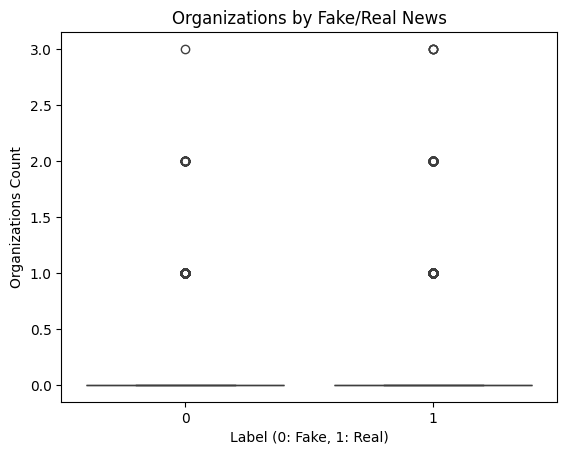

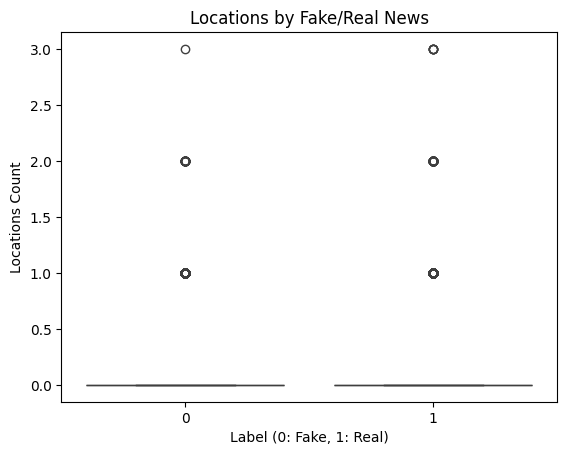

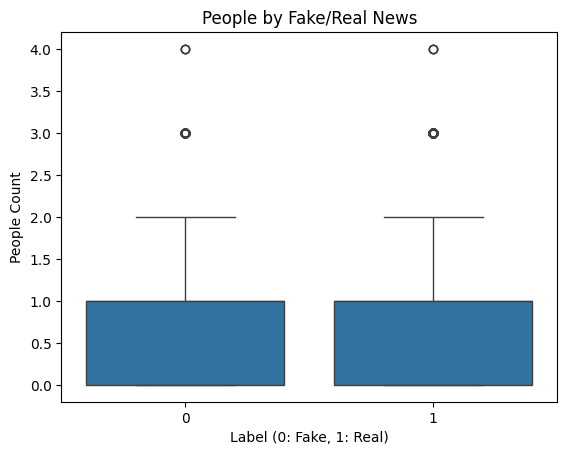

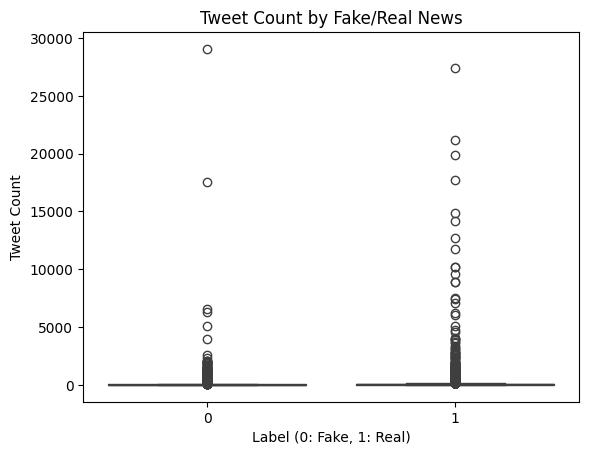

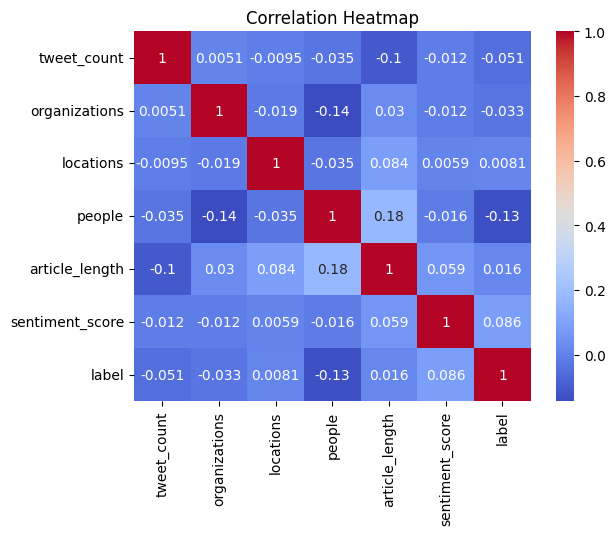

In [10]:
# 4 . Visualization{
# Box plot for named entities vs label (fake/real)
for col in ["organizations", "locations", "people"]:
  sns.boxplot(data=dataset, x="label", y=col)
  plt.title(f"{col.capitalize()} by Fake/Real News")
  plt.xlabel("Label (0: Fake, 1: Real)")
  plt.ylabel(f"{col.capitalize()} Count")
  plt.show()

# Box plot for tweet count vs label
sns.boxplot(data=dataset, x="label", y="tweet_count")
plt.title("Tweet Count by Fake/Real News")
plt.xlabel("Label (0: Fake, 1: Real)")
plt.ylabel("Tweet Count")
plt.show()

# Correlation Heatmap
corr_matrix = dataset[["tweet_count", "organizations", "locations", "people", "article_length", "sentiment_score", "label"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [11]:
# 5. Predictive Modeling
# Define features and target variable
features = ["tweet_count", "organizations", "locations", "people", "article_length", "sentiment_score"]
x = dataset[features]
y = dataset["label"]

#Train-test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

#Predictions
y_pred = model.predict(x_test)

#Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Model Accuracy:  0.80
Model F1 Score:  0.87


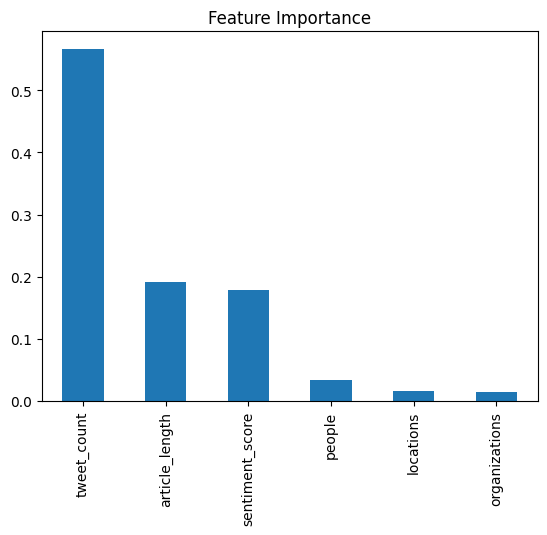

In [14]:
print(f"Model Accuracy: {accuracy: .2f}")
print(f"Model F1 Score: {f1: .2f}")

#Feature Importance
importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
importance.plot(kind="bar", title="Feature Importance")
plt.show()